In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#hide
!pip install -Uqq fastbook

     |████████████████████████████████| 719 kB 3.6 MB/s 
     |████████████████████████████████| 4.2 MB 65.9 MB/s 
     |████████████████████████████████| 1.2 MB 58.4 MB/s 
     |████████████████████████████████| 197 kB 70.8 MB/s 
     |████████████████████████████████| 362 kB 62.6 MB/s 
     |████████████████████████████████| 60 kB 8.9 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 212 kB 73.8 MB/s 
     |████████████████████████████████| 140 kB 75.3 MB/s 
     |████████████████████████████████| 1.1 MB 55.4 MB/s 
     |████████████████████████████████| 596 kB 46.2 MB/s 
     |████████████████████████████████| 127 kB 75.6 MB/s 
     |████████████████████████████████| 144 kB 71.9 MB/s 
     |████████████████████████████████| 271 kB 72.2 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the p

In [ ]:
## pytorch and fastai installation ##

# conda install pytorch torchvision torchaudio cpuonly -c pytorch

## Install fastbook and fastai with this command ##

 # conda install -c fastai fastbook

In [3]:
import fastbook
fastbook.setup_book()

In [4]:
# https://fastai1.fast.ai/text.html#:~:text=The%20text%20module%20of%20the,you%20can%20use%20for%20them.
from fastbook import *
from fastai.text.all import *

# The text module of the fastai library contains all the necessary functions to define a Dataset suitable for the various NLP (Natural Language Processing) tasks and quickly generate models you can use for them.

from IPython.display import display,HTML

__Universal Language Model Fine-tuning (ULMFiT)__, an effective transfer learning method that can be applied to any task in NLP and introduce techniques that are key for ﬁne-tuning a language model. 

ULMFiT-based models (which have been pre-trained) perform very well even on small and medium datasets compared to models trained from scratch on the corresponding dataset.

`fastai`  library is focused on using pre-trained Language Models and fine-tuning them, done in below three steps:

1.   Data pre-processing in a minimum amount of code.
2.   Create a language model with pre-trained weights that you can fine-tune to your dataset.
3.   Create other models such as classifiers on top of the language model.











# What is Language Model


Language model is a model that has been trained to guess what the next word in a text is (having read the ones before). This kind of task is called *self-supervised learning*: we do not need to give labels to our model, just feed it lots and lots of texts. It has a process to automatically get labels from the data, and this task isn't trivial: to properly guess the next word in a sentence, the model will have to develop an understanding of the English (or other) language. Self-supervised learning is not usually used for the model that is trained directly, but instead is used for pretraining a model used for transfer learning.

> jargon: Self-supervised learning: Training a model using labels that are embedded in the independent variable, rather than requiring external labels. For instance, training a model to predict the next word in a text.

__Overview of ULMFiT__

Proposed by fast.ai’s Jeremy Howard and NUI Galway Insight Center’s Sebastian Ruder, ULMFiT is essentially a method to enable transfer learning for any NLP task and achieve great results. All this, without having to train models from scratch. 

**ULMFiT** achieves state-of-the-art result using novel techniques like:

1.  Discriminative fine-tuning
2.  Slanted triangular learning rates, and
3.  Gradual unfreezing
This method involves fine-tuning a pre-trained language model (LM), trained on the Wikitext 103 dataset, to a new dataset in such a manner that it does not forget what it previously learned.

The language model used in this exercise was pre-trained on Wikipedia. Even though we can get great results by directly fine-tuning this language model to a movie review classifier, but with one extra step, we can do even better. The Wikipedia English is slightly different from the IMDb English, so instead of jumping directly to the classifier, we could fine-tune our pretrained language model to the IMDB corpus and then use **that** as the base for our classifier.

Even if our language model knows the basics of the language we are using in the task (e.g., our pretrained model is in English), it helps to get used to the style of the corpus we are targeting. It may be more informal language, or more technical, with new words to learn or different ways of composing sentences. In the case of the IMDb dataset, there will be lots of names of movie directors and actors, and often a less formal style of language than that seen in Wikipedia.


This is known as the Universal Language Model Fine-tuning (ULMFit) approach. The [paper](https://arxiv.org/abs/1801.06146) showed that this extra stage of fine-tuning of the language model, prior to transfer learning to a classification task, resulted in significantly better predictions. Using this approach, we have three stages for transfer learning in NLP, as summarized in below diagram

<img alt="Diagram of the ULMFiT process" width="700" caption="The ULMFiT process" id="ulmfit_process" src="https://github.com/fastai/fastbook/blob/master/images/att_00027.png?raw=1">

## Text Preprocessing

It's not at all obvious how we're going to use what we've learned so far to build a language model. Sentences can be different lengths, and documents can be very long. So, how can we predict the next word of a sentence using a neural network? Let's find out!

What is new is the idea of a sequence. First we concatenate all of the documents in our dataset into one big long string and split it into words, giving us a very long list of words (or "tokens"). Our independent variable will be the sequence of words starting with the first word in our very long list and ending with the second to last, and our dependent variable will be the sequence of words starting with the second word and ending with the last word. 

__Our vocab will consist of a mix of common words that are already in the vocabulary of our pretrained model and new words specific to our corpus (cinematographic terms or actors names, for instance).__ Our embedding matrix will be built accordingly: for words that are in the vocabulary of our pretrained model, we will take the corresponding row in the embedding matrix of the pretrained model; but for new words we won't have anything, so we will just initialize the corresponding row with a random vector.

Each of the steps necessary to create a language model has jargon associated with it from the world of natural language processing, and fastai and PyTorch classes available to help. The steps are:

- Tokenization:: Convert the text into a list of words (or characters, or substrings, depending on the granularity of your model)
- Numericalization:: Make a list of all of the unique words that appear (the vocab), and convert each word into a number, by looking up its index in the vocab
- Language model data loader creation:: fastai provides an `LMDataLoader` class which automatically handles creating a dependent variable that is offset from the independent variable by one token. It also handles some important details, such as how to shuffle the training data in such a way that the dependent and independent variables maintain their structure as required
- Language model creation:: We need a special kind of model that does something we haven't seen before: handles input lists which could be arbitrarily big or small. There are a number of ways to do this; in this code, we will be using a *recurrent neural network* (RNN).

Let's take a look at how each step works in detail.

### Word Tokenization with fastai

Rather than providing its own tokenizers, fastai instead provides a consistent interface to a range of tokenizers in external libraries. Tokenization is an active field of research, and new and improved tokenizers are coming out all the time, so the defaults that fastai uses change too. However, the API and options shouldn't change too much, since fastai tries to maintain a consistent API even as the underlying technology changes.

The default English word tokenizer for fastai uses a library called *spaCy*. It has a sophisticated rules engine with special rules for URLs, individual special English words, and much more. Rather than directly using `SpacyTokenizer`, however, we'll use `WordTokenizer`, since that will always point to fastai's current default word tokenizer (which may not necessarily be spaCy).

In [5]:
txt = "Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [6]:
spacy = WordTokenizer()
toks = first(spacy([txt]))
toks

(#154) ['Basically','there',"'s",'a','family','where','a','little','boy','('...]

In [7]:
print(coll_repr(toks, 50))

(#154) ['Basically','there',"'s",'a','family','where','a','little','boy','(','Jake',')','thinks','there',"'s",'a','zombie','in','his','closet','&','his','parents','are','fighting','all','the','time.<br','/><br','/>This','movie','is','slower','than','a','soap','opera','...','and','suddenly',',','Jake','decides','to','become','Rambo','and','kill','the','zombie.<br'...]


In [8]:
doc(coll_repr)

coll_repr(c, max_n=10)
String repr of up to `max_n` items of (possibly lazy) collection `c`

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [9]:
first(spacy(['The U.S. dollar $1 is $1.00.']))

(#9) ['The','U.S.','dollar','$','1','is','$','1.00','.']

fastai then adds some additional functionality to the tokenization process with the `Tokenizer` class:

In [10]:
tkn = Tokenizer(spacy)
print(coll_repr(tkn(txt), 50))

(#171) ['xxbos','xxmaj','basically','there',"'s",'a','family','where','a','little','boy','(','jake',')','thinks','there',"'s",'a','zombie','in','his','closet','&','his','parents','are','fighting','all','the','time','.','\n\n','xxmaj','this','movie','is','slower','than','a','soap','opera','…','and','suddenly',',','xxmaj','jake','decides','to','become'...]


The rules are all listed below, here is the meaning of the special tokens:

- `UNK (xxunk)` is for an unknown word (one that isn't present in the current vocabulary)
- `PAD (xxpad)` is the token used for padding, if we need to regroup several texts of different lengths in a batch
- `BOS (xxbos)` represents the beginning of a text in your dataset
- `FLD (xxfld)` is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
- `TK_MAJ (xxmaj)` is used to indicate the next word begins with a capital in the original text
- `TK_UP (xxup)` is used to indicate the next word is written in all caps in the original text
- `TK_REP (xxrep)` is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
- `TK_WREP(xxwrep)` is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

Here is a brief summary of what each does:

- `fix_html`:: Replaces special HTML characters with a readable version (IMDb reviews have quite a few of these)
- `replace_rep`:: Replaces any character repeated three times or more with a special token for repetition (`xxrep`), the number of times it's repeated, then the character
- `replace_wrep`:: Replaces any word repeated three times or more with a special token for word repetition (`xxwrep`), the number of times it's repeated, then the word
- `spec_add_spaces`:: Adds spaces around / and #
- `rm_useless_spaces`:: Removes all repetitions of the space character
- `replace_all_caps`:: Lowercases a word written in all caps and adds a special token for all caps (`xxcap`) in front of it
- `replace_maj`:: Lowercases a capitalized word and adds a special token for capitalized (`xxmaj`) in front of it
- `lowercase`:: Lowercases all text and adds a special token at the beginning (`xxbos`) and/or the end (`xxeos`)

### Reading IMDB data and Preparing Dataframe for DataLoader 

In [11]:
data = pd.read_csv('/content/gdrive/My Drive/NLP/Lab04/IMDB_Dataset.csv', header=0)
data.shape

(50000, 2)

In [12]:
data.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses main...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his ...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've ...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with so...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of conta...",positive


In [13]:
data.columns = ['text', 'label']

In [14]:
data.head()

,text,label
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses main...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his ...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've ...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with so...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of conta...",positive


### Language Model Using DataBlock

fastai handles tokenization and numericalization automatically when `TextBlock` is passed to `DataBlock`. All of the arguments that can be passed to `Tokenize` and `Numericalize` can also be passed to `TextBlock`.

Here's how we use `TextBlock` to create a language model, using fastai's defaults:

In [15]:
# https://docs.fast.ai/tutorial.datablock.html
# A DataBlock is just a blue print on how to assemble our data. It does not do anything until you pass it a source. 

# https://docs.fast.ai/text.data.html

dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(0.1)
).dataloaders(data, bs=128, seq_len=72)

In [16]:
len(dls_lm.vocab)

52072

In [17]:
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj absolutely one of the worst movies of the year . xxmaj the plot is ridiculous , the characters poorly developed , and the premise irritatingly stupid . xxmaj it all begins when xxmaj michael xxmaj keaton , fresh off of doing nothing noteworthy since xxmaj batman , loses his beautiful author wife , xxmaj anna , to a car accident , possibly caused by her driving one of those convertible","xxmaj absolutely one of the worst movies of the year . xxmaj the plot is ridiculous , the characters poorly developed , and the premise irritatingly stupid . xxmaj it all begins when xxmaj michael xxmaj keaton , fresh off of doing nothing noteworthy since xxmaj batman , loses his beautiful author wife , xxmaj anna , to a car accident , possibly caused by her driving one of those convertible xxup"
1,"as we get to know xxmaj charles and xxmaj andy , the thought of xxmaj andy forming a plan to rob from his father becomes less unbelievable . \n\n xxmaj on a personal note , i can not believe how much xxmaj charles xxmaj hanson reminded me of my own father , and how much xxmaj andy and xxmaj hank reminded me of my own brother and myself . xxmaj perhaps this","we get to know xxmaj charles and xxmaj andy , the thought of xxmaj andy forming a plan to rob from his father becomes less unbelievable . \n\n xxmaj on a personal note , i can not believe how much xxmaj charles xxmaj hanson reminded me of my own father , and how much xxmaj andy and xxmaj hank reminded me of my own brother and myself . xxmaj perhaps this may"
2,"ending is very artificial and unbelievable . xxmaj any stereotypes one might have about xxmaj german comedy are sadly reinforced . \n\n xxmaj the characters are stereotypes one and all , and the leading character , played by xxmaj kim xxmaj frank , is colourless in the extreme . xxmaj he just can not carry the film and appears to have been chosen largely for his baby face . xxmaj it may","is very artificial and unbelievable . xxmaj any stereotypes one might have about xxmaj german comedy are sadly reinforced . \n\n xxmaj the characters are stereotypes one and all , and the leading character , played by xxmaj kim xxmaj frank , is colourless in the extreme . xxmaj he just can not carry the film and appears to have been chosen largely for his baby face . xxmaj it may not"


Now that our data is ready, we can fine-tune the pretrained language model.

### Fine-Tuning the Language Model

To convert the integer word indices into activations that we can use for our neural network, we will use embeddings. Then we'll feed those embeddings into a *recurrent neural network* (RNN), using an architecture called *AWD-LSTM*. The link to the paper https://arxiv.org/abs/1708.02182 <br>

AWD-LSTM stands for **ASGD Weight Dropout LSTM**. The AWD-LSTM has been dominating the state-of-the-art language modeling. All the top research papers on word-level models incorporate AWD-LSTMs. 

As we discussed earlier, the embeddings in the pretrained model are merged with random embeddings added for words that weren't in the pretraining vocabulary. This is handled automatically inside `language_model_learner`:

In [18]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy]).to_fp16()

Let's go back to the process diagram from the beginning of this chapter. The first arrow has been completed for us and made available as a pretrained model in fastai, and we've just built the `DataLoaders` and `Learner` for the second stage. Now we're ready to fine-tune our language model!

<img alt="Diagram of the ULMFiT process" width="750" src="https://github.com/fastai/fastbook/blob/master/images/att_00027.png?raw=1">

SuggestedLRs(valley=0.002511886414140463)

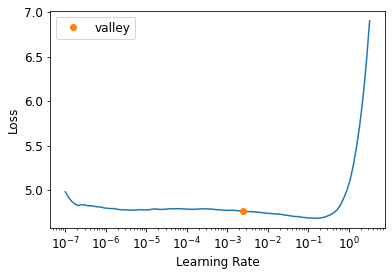

In [19]:
learn.lr_find()

`language_model_learner` automatically calls `freeze` when using a pretrained model (which is the default), so this will only train the embeddings (the only part of the model that contains randomly initialized weights—i.e., embeddings for words that are in our IMDb vocab, but aren't in the pretrained model vocab):

In [20]:
learn.fit_one_cycle(1, 0.002512)

epoch,train_loss,valid_loss,accuracy,time
0,4.129789,4.028753,0.292464,29:12


### Saving and Loading Models

You can easily save the state of your model like so:

In [21]:
learn.save('1epoch')

Path('models/1epoch.pth')

This will create a file in `learn.path/models/` named *1epoch.pth*. If you want to load your model in another machine after creating your `Learner` the same way, or resume training later, you can load the content of this file with:

In [22]:
learn = learn.load('1epoch')

Once the initial training has completed, we can continue fine-tuning the model after unfreezing:

In [23]:
learn.unfreeze()
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.897510,3.856635,0.308277,30:27
1,3.678041,3.704646,0.325113,30:25
2,3.486605,3.669569,0.330031,30:30


Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the *encoder*. We can save it with `save_encoder`:

In [24]:
learn.save_encoder('finetuned')

This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### Text Generation

Before we move on to fine-tuning the classifier, let's quickly try something different: using our model to generate random reviews. Since it's trained to guess what the next word of the sentence is, we can use the model to write new reviews:

In [25]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) # Lowering temperature will make the texts less randomized.
         for _ in range(N_SENTENCES)]

In [32]:
print("\n".join(preds))

i liked this movie because the characters were interesting and i felt a little bit cheated . i do n't think the movie has any depth , i felt like i was watching an action movie . It was n't . It was
i liked this movie because of a really good acting by Myrna Loy . Her delivery of the lines was quite convincing , and in my opinion she does a great job . i ca n't quite say why i liked this


As you can see, we add some randomness (we pick a random word based on the probabilities returned by the model) so we don't get exactly the same review twice. Our model doesn't have any programmed knowledge of the structure of a sentence or grammar rules, yet it has clearly learned a lot about English sentences: we can see it capitalizes properly (*I* is just transformed to *i* because our rules require two characters or more to consider a word as capitalized, so it's normal to see it lowercased) and is using consistent tense. The general review makes sense at first glance, and it's only if you read carefully that you can notice something is a bit off. Not bad for a model trained in a couple of hours! 

But our end goal wasn't to train a model to generate reviews, but to classify them... so let's use this model to do just that.

### Creating the Classifier DataLoaders

We're now moving from language model fine-tuning to classifier fine-tuning. To recap, a language model predicts the next word of a document, so it doesn't need any external labels. A classifier, however, predicts some external label—in the case of IMDb, it's the sentiment of a document.

This means that the structure of our `DataBlock` for NLP classification will look very familiar. It's actually nearly the same as we've seen for the many image classification datasets we've worked with:

In [27]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab),CategoryBlock),
    get_x=ColReader('text'), 
    get_y=ColReader('label'), 
    splitter=RandomSplitter(0.1)
).dataloaders(data, bs=128, seq_len=72)

In [28]:
dls_clas.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german suplex by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",positive
1,"xxbos i thought that xxup rotj was clearly the best out of the three xxmaj star xxmaj wars movies . i find it surprising that xxup rotj is considered the weakest installment in the xxmaj trilogy by many who have voted . xxmaj to me it seemed like xxup rotj was the best because it had the most profound plot , the most suspense , surprises , most xxunk the ending ) and definitely the most episodic movie . i personally like the xxmaj empire xxmaj strikes xxmaj back a lot also but i think it is slightly less good than than xxup rotj since it was slower - moving , was not as episodic , and i just did not feel as much suspense or emotion as i did with the third movie . \n\n xxmaj it also seems like to me that after reading these surprising reviews that",positive
2,"xxbos xxmaj polish film maker xxmaj walerian xxmaj borowczyk 's xxmaj la xxmaj bête ( french , 1975 , aka xxmaj the xxmaj beast ) is among the most controversial and brave films ever made and a very excellent one too . xxmaj this film tells everything that 's generally been hidden and denied about our nature and our sexual nature in particular with the symbolism and silence of its images . xxmaj the images may look wild , perverse , "" sick "" or exciting , but they are all in relation with the lastly mentioned . xxmaj sex , desire and death are very strong and primary things and dominate all the flesh that has a human soul inside it . xxmaj they interest and xxunk us so powerfully ( and by our nature ) that they are considered scary , unacceptable and something too wild to be",positive


Looking at the `DataBlock` definition, every piece is familiar from previous data blocks we've built, with two important exceptions:

- `TextBlock.from_df` no longer has the `is_lm=True` parameter.
- We pass the `vocab` we created for the language model fine-tuning.

The reason that we pass the `vocab` of the language model is to make sure we use the same correspondence of token to index. Otherwise the embeddings we learned in our fine-tuned language model won't make any sense to this model, and the fine-tuning step won't be of any use.

By passing `is_lm=False` (or not passing `is_lm` at all, since it defaults to `False`) we tell `TextBlock` that we have regular labeled data, rather than using the next tokens as labels.

In [29]:
learn_cls = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.0020892962347716093)

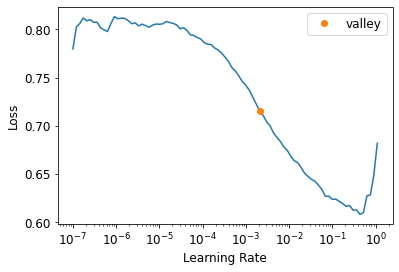

In [30]:
learn_cls.lr_find()

The final step prior to training the classifier is to load the encoder from our fine-tuned language model. We use `load_encoder` instead of `load` because we only have pretrained weights available for the encoder; `load` by default raises an exception if an incomplete model is loaded:

In [31]:
learn_cls = learn_cls.load_encoder('finetuned')

### Fine-Tuning the Classifier

The last step is to train with discriminative learning rates and *gradual unfreezing*. For NLP classifiers, we find that unfreezing a few layers at a time makes a real difference:

#### Information about fit_one_cycle() method

fit_one_cycle() uses large, cyclical learning rates to train models significantly quicker and with higher accuracy.

fit_one_cycle() is Fastai’s implementation of Leslie Smith’s 1cycle policy.
Link to the paper: https://arxiv.org/abs/1506.01186 & https://arxiv.org/abs/1708.07120 <br>


__Problem with Learning Rate:__<br>
Learning Rate (LR) is a crucial hyper-parameter to tune when training DNNs. A very small learning rate can lead to very slow training, while a very large learning rate can hinder convergence as the loss function fluctuates around the minimum, or even diverges.<br>

Finding the sweet spot requires experimentation and patience. An automated way of calculating the optimal learning rate is to perform a grid search, but this is a time consuming process.

In practice, learning rate is not static but changes as training progresses.

It is desirable to start with an optimal learning rate (for speed) and gradually decrease it towards the end (for accuracy).

Smith discovered a new method for setting learning rate, named Cyclical Learning Rates (CLRs). Instead of using a fixed, or a decreasing learning rate, the CLR method allows learning rate to continuously oscillate between reasonable minimum and maximum bounds.

More Information at : https://iconof.com/1cycle-learning-rate-policy/

In [33]:
learn_cls.fit_one_cycle(1, 0.00209)

epoch,train_loss,valid_loss,accuracy,time
0,0.254997,0.198575,0.924600,01:59


We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups:

In [34]:
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.220195,0.163571,0.940200,02:27


Then we can unfreeze a bit more, and continue training:

In [35]:
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.175706,0.142839,0.950000,03:58


And finally, the whole model!

In [36]:
learn_cls.unfreeze()
learn_cls.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.155097,0.141812,0.949000,05:26
1,0.138740,0.136187,0.949800,05:26


*We* reached 94% accuracy, which was state-of-the-art performance just three years ago. By training another model on all the texts read backwards and averaging the predictions of those two models, we can even get to 95.1% accuracy, which was the state of the art introduced by the ULMFiT paper.

### Saving the entire model as pkl file

In [37]:
learn_cls.export(fname='./imdb.pkl')

In [39]:
loaded_model = load_learner('./imdb.pkl',cpu=False) # if model needs to be run on cpu make sure cpu=True

In [40]:
loaded_model.model     # loaded_model contains both encoder and pooling linear classifier

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(52072, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(52072, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True

### Predictions

In [41]:
learn_cls.show_results()

,text,category,category_
0,"xxbos * ! ! - xxup spoilers - ! ! * \n\n xxmaj before i begin this , let me say that i have had both the advantages of seeing this movie on the big screen and of having seen the "" authorized xxmaj version "" of this movie , remade by xxmaj stephen xxmaj king , himself , in 1997 . \n\n xxmaj both advantages made me appreciate this version of "" the xxmaj shining , "" all the more . \n\n xxmaj also , let me say that xxmaj i 've read xxmaj mr . xxmaj king 's book , "" the xxmaj shining "" on many occasions over the years , and while i love the book and am a huge fan of his work , xxmaj stanley xxmaj kubrick 's retelling of this story is far more compelling … and xxup scary . \n\n xxmaj kubrick",positive,positive
1,"xxbos xxrep 3 * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . xxrep 3 * \n\n xxmaj before i begin , xxmaj i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that - you - fall - over - laughing movies . xxmaj if you 're in a lighthearted mood and need a very hearty laugh , this is the movie for you . xxmaj now without further ado , my review : \n\n xxmaj this movie was found in a bargain bin at wal - mart . xxmaj that should be the first clue as to how good of a movie it is . xxmaj secondly , it stars the lame action",negative,negative
2,"xxbos xxmaj this movie was recently released on xxup dvd in the xxup us and i finally got the chance to see this hard - to - find gem . xxmaj it even came with original theatrical previews of other xxmaj italian horror classics like "" xxunk "" and "" beyond xxup the xxup darkness "" . xxmaj unfortunately , the previews were the best thing about this movie . \n\n "" zombi 3 "" in a bizarre way is actually linked to the infamous xxmaj lucio xxmaj fulci "" zombie "" franchise which began in 1979 . xxmaj similarly compared to "" zombie "" , "" zombi 3 "" consists of a threadbare plot and a handful of extremely bad actors that keeps this ' horror ' trash barely afloat . xxmaj the gore is nearly non - existent ( unless one is frightened of people running around with",negative,negative
3,"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n\n xxmaj the xxmaj warriors ( ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ) : xxmaj ax is the first to go in seconds when xxmaj warrior splashes him for the pin ( 4 - 3 adv . xxmaj warriors ) . i knew xxmaj ax was n't a healthy man but if he was that unhealthy why bother have him on the card ? xxmaj this would be his last xxup ppv . xxmaj eventually , both xxmaj legion of xxmaj doom and xxmaj demolition job out cheaply via double disqualification ( 2 - 1 adv . xxmaj warriors ) . xxmaj perfect",negative,negative
4,"xxbos xxmaj i 've rented and watched this movie for the 1st time on xxup dvd without reading any reviews about it . xxmaj so , after 15 minutes of watching xxmaj i 've noticed that something is wrong with this movie ; it 's xxup terrible ! i mean , in the trailers it looked scary and serious ! \n\n i think that xxmaj eli xxmaj roth ( mr . xxmaj director ) thought that if all the characters in this film were stupid , the movie would be funny … ( so stupid , it 's funny … ? xxup wrong ! ) xxmaj he should watch and learn from better horror - comedies such xxunk xxmaj night "" , "" the xxmaj lost xxmaj boys "" and "" the xxmaj return xxmaj of the xxmaj living xxmaj dead "" ! xxmaj those are funny ! \n\n """,negative,negative
5,"xxbos i felt duty bound to watch the 1983 xxmaj timothy xxmaj dalton / xxmaj zelah xxmaj clarke adaptation of "" jane xxmaj eyre , "" because xxmaj i 'd just written an article about the 2006 xxup bbc "" jane xxmaj eyre "" for xxunk . \n\n xxmaj so , i approached watching t

In [47]:
loaded_model.predict('I like the movie a lot, good story and great cast.')

('positive', TensorText(1), TensorText([0.0310, 0.9690]))

In [46]:
loaded_model.predict('The product look good from packaging but the quality was pathetic.')

('negative', TensorText(0), TensorText([0.9917, 0.0083]))

In [49]:
loaded_model.predict('The car gives OK mileage when driven on city roads.')

('negative', TensorText(0), TensorText([0.7146, 0.2854]))